# Sample a broken power law... fast!

Inspired by discussions, with Johannes Buchner. 

Rejection sampling of power laws quiet frankly sucks. They exist all throughout astrophysics. Thankfully, inverse transform sampling allows for a quite speedy work around. However, there is no direct inverse transform for a broken power law. Instead, I show herein how to sample from two power laws that are step-wise continuous via a weighted Bernoulli sampling combined with inverse transform sampling. 

In [13]:
# Import some things

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
#plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)
plt.style.use('mike') 

## First we define some utility functions
Here we define two important functions. One, naturally, is the broken power law function we would like to sample. Second, defines the total integral of the function to normalize it, as well as the integrals of each piece of the power law.

In [6]:
def integrate_pl(x0, x1, x2, a1, a2):
    """
    x0: lower bound
    x1: break point
    x2: upper bound
    a1: lower power law index
    a2: upper power low index
    
    """
    
    # compute the integral of each piece analytically
    int_1 = (np.power(x1, a1+1.) - np.power(x0, a1+1.))/(a1+1)
    int_2 = np.power(x1,a1-a2)*(np.power(x2, a2+1.) - np.power(x1, a2+1.))/(a2+1)
    
    # compute the total integral
    total = int_1 + int_2
    
    # compute the weights of each piece of the function
    w1 = int_1/total
    w2 = int_2/total
    
    return w1, w2, total
    
    
def bpl(x,x0, x1, x2, a1, a2):
    """
    x: the domain of the function
    x0: lower bound
    x1: break point
    x2: upper bound
    a1: lower power law index
    a2: upper power low index
    
    """
    
    # creatre a holder for the values
    out = np.empty_like(x)
    
    # get the total integral to compute the normalization
    _,_,C = integrate_pl(x0, x1, x2, a1, a2)
    norm = 1./C
    
    # create an index to select each piece of the function
    idx = x<x1
    
    # compute the lower power law
    out[idx] = np.power(x[idx],a1)
    
    # compute the upper power law
    out[~idx] = np.power(x[~idx],a2) * np.power(x1,a1-a2)
    
    return out* norm
    
    
    

<IPython.core.display.Javascript object>


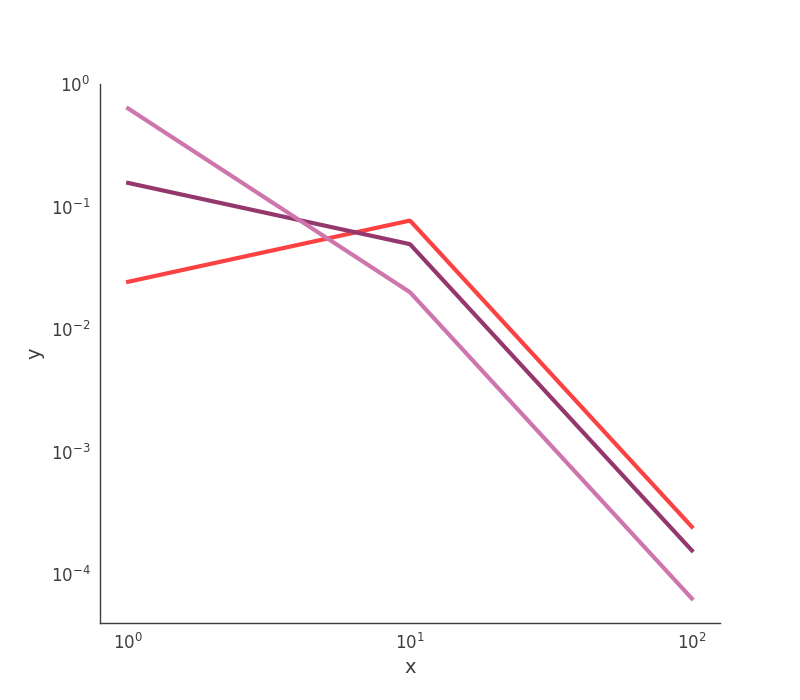

Text(0, 0.5, 'y')

In [15]:
fig, ax = plt.subplots()

xx = np.logspace(0,2,500)

for idx in [0.5, -0.5,-1.5]:

    ax.loglog(xx,  bpl(xx, x0=1, x1=10, x2=100, a1=idx, a2=-2.5),lw=3)

ax.set_xlabel('x')
ax.set_ylabel('y')

## Sampling

To sample this distribution, we exploit the inverse transform of each piece of the function. We first compute the *weight* of each power law to the total function. Then we sample a Bernoulli trial with one of the weights. It does not matter which side of the function we choose for this as long as the index of the trails lines up.

In [16]:
def sample_bpl(u, x0, x1, x2, a1, a2):
    """
    u: uniform random number between on {0,1}
    x0: lower bound
    x1: break point
    x2: upper bound
    a1: lower power law index
    a2: upper power low index
    """

    # compute the weights with our integral function
    w1, w2, _ = integrate_pl(x0, x1, x2, a1, a2)

    # create a holder array for our output
    out = np.empty_like(u)

    # compute the bernoulli trials for lower piece of the function
    # *if we wanted to do the upper part... we just reverse our index*
    # We also compute these to bools for numpy array selection
    idx = stats.bernoulli.rvs(w1, size=len(u)).astype(bool)

    # inverse transform sample the lower part for the "successes"
    out[idx] = np.power(
        u[idx] * (np.power(x1, a1 + 1.0) - np.power(x0, a1 + 1.0))
        + np.power(x0, a1 + 1.0),
        1.0 / (1 + a1),
    )
    
    # inverse transform sample the upper part for the "failures"
    out[~idx] = np.power(
        u[~idx] * (np.power(x2, a2 + 1.0) - np.power(x1, a2 + 1.0))
        + np.power(x1, a2 + 1.0),
        1.0 / (1 + a2),
    )
    
    
    return out

Let's generate 10000 uniformly distributed random numbers

In [17]:
u= np.random.uniform(0,1, 10000)

Now sample the distribution

In [26]:
# values we will use
x0 = 1.0
x1 = 10.0
x2 = 100.0
a1 = 0.5
a2 = -3.4

samples = sample_bpl(u, x0=x0, x1=x1, x2=x2, a1=a1, a2=a2)

We can histogram our samples and then compare with the function from which we sampled. 

<IPython.core.display.Javascript object>


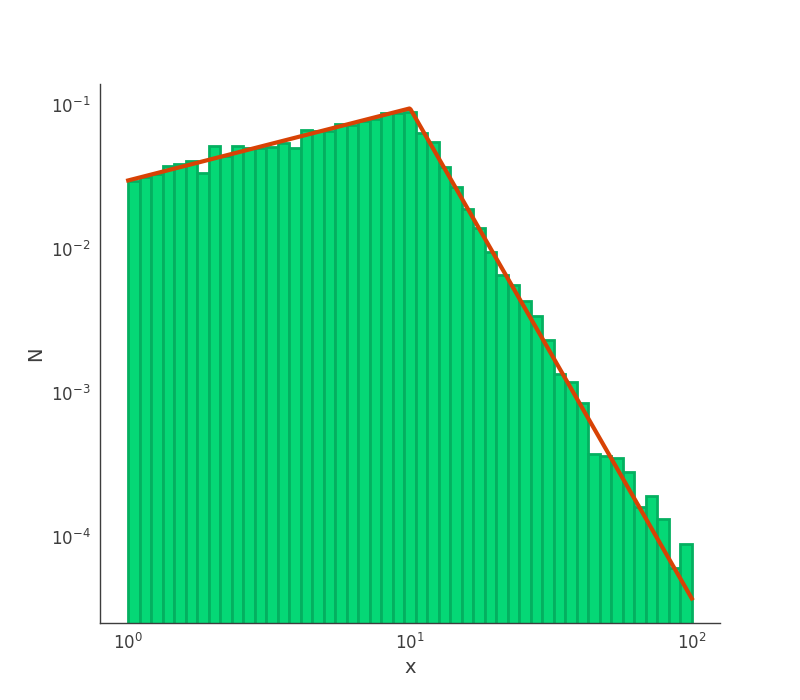

Text(0, 0.5, 'N')

In [30]:
fig, ax = plt.subplots()

# create log-spaced bins
bins = np.logspace(np.log10(x0), np.log10(x2), 50)

# histogram
ax.hist(samples, bins=bins, ec="#04B060", fc="#05D876", normed=True, lw=2)

# switch to log-sapce
ax.set_xscale("log")
ax.set_yscale("log")

# plot the original function we sampled from 

xx = np.logspace(np.log10(x0), np.log10(x2),500)

ax.plot(xx, bpl(xx,  x0=x0, x1=x1, x2=x2, a1=a1, a2=a2), color="#D84205", lw=3)

ax.set_xlabel('x')
ax.set_ylabel('N')